In [48]:
#Impoting Libraries Required
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')

In [49]:
feature_extraction_algo = 'sift'
feature_to_match = 'bf'

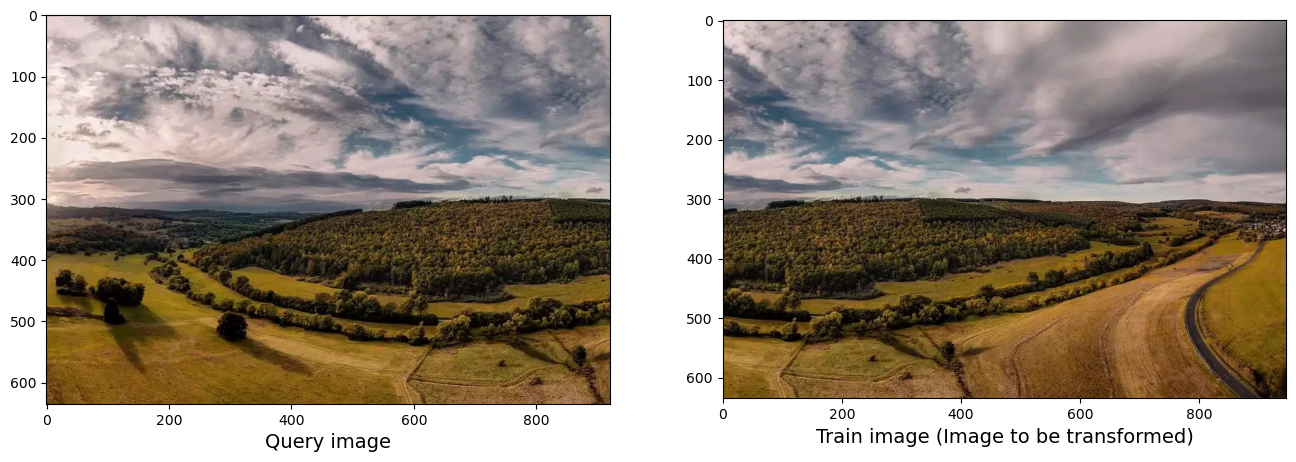

In [50]:
#  Image that will be transformed
train_photo = cv2.imread('./'  + 'train.jpg')


#Converting to RGB for Matplotlib
train_photo = cv2.cvtColor(train_photo,cv2.COLOR_BGR2RGB)

train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

query_photo = cv2.imread('./'  + 'query.jpg')
query_photo = cv2.cvtColor(query_photo,cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)

# Now view/plot the images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(query_photo, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(train_photo, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)
plt.savefig("./_"+'.jpeg', bbox_inches='tight', dpi=300, optimize=True, format='jpeg')

plt.show()

In [51]:
def select_descriptor_methods(image, method=None):    
    
    assert method is not None, "Please define a feature descriptor method. accepted Values are: 'sift', 'surf'"
    
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    (keypoints, features) = descriptor.detectAndCompute(image, None)
    
    return (keypoints, features)

In [52]:
keypoints_train_img, features_train_img = select_descriptor_methods(train_photo_gray, method=feature_extraction_algo)
keypoints_query_img, features_query_img = select_descriptor_methods(query_photo_gray, method=feature_extraction_algo)

In [53]:
for keypoint in keypoints_query_img:
    x,y = keypoint.pt
    size = keypoint.size 
    orientation = keypoint.angle
    response = keypoint.response 
    octave = keypoint.octave
    class_id = keypoint.class_id


print (x,y)
print(size)
print(orientation)
print(response)
print(octave)
print(class_id)

917.5430908203125 470.8984375
2.304771900177002
81.46585083007812
0.026408405974507332
1311487
-1


In [54]:
print(len(keypoints_query_img))

features_query_img.shape

3530


(3530, 128)

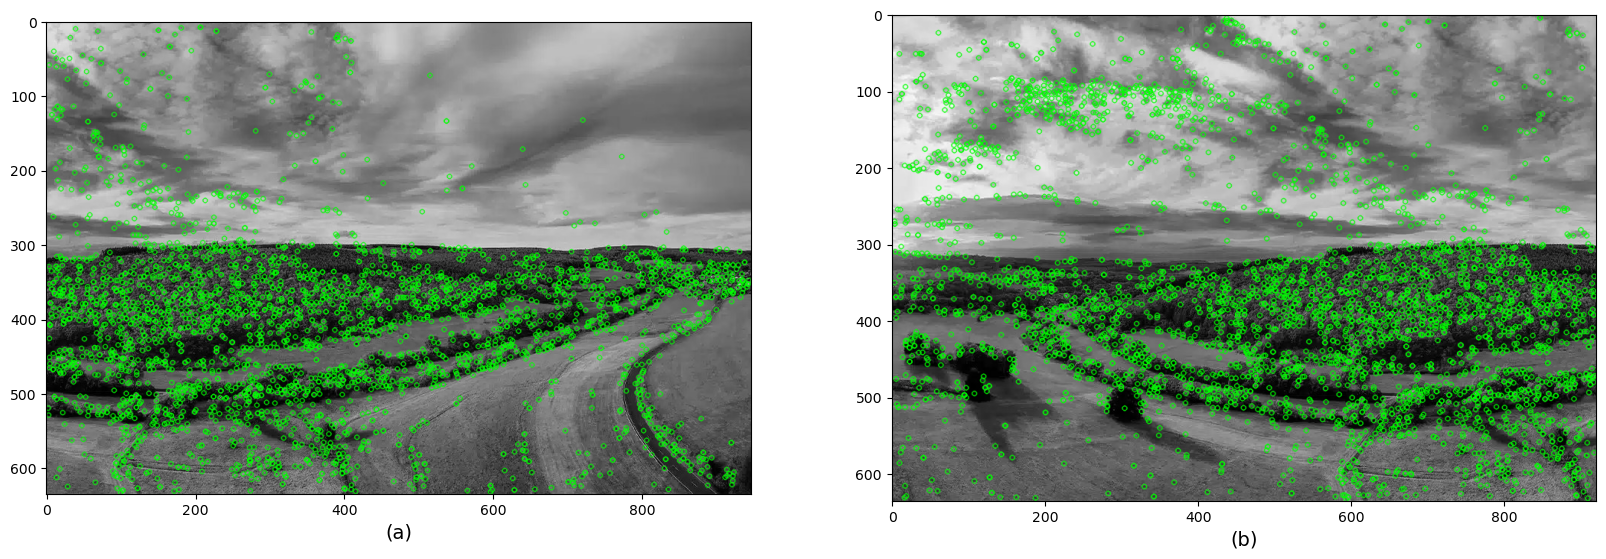

In [55]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)

ax1.imshow(cv2.drawKeypoints(train_photo_gray, keypoints_train_img, None, color=(0,255,0)))

ax1.set_xlabel("(a)", fontsize=14)

ax2.imshow(cv2.drawKeypoints(query_photo_gray,keypoints_query_img,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [56]:
def create_matching_object(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [57]:
def key_points_matching(features_train_img, features_query_img, method):

    bf = create_matching_object(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(features_train_img,features_query_img)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches with Brute force):", len(rawMatches))
    return rawMatches

In [58]:
def key_points_matching_KNN(features_train_img, features_query_img, ratio, method):

    bf = create_matching_object(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(features_train_img, features_query_img, k=2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Drawing: bf matched features Lines
Raw matches with Brute force): 1735


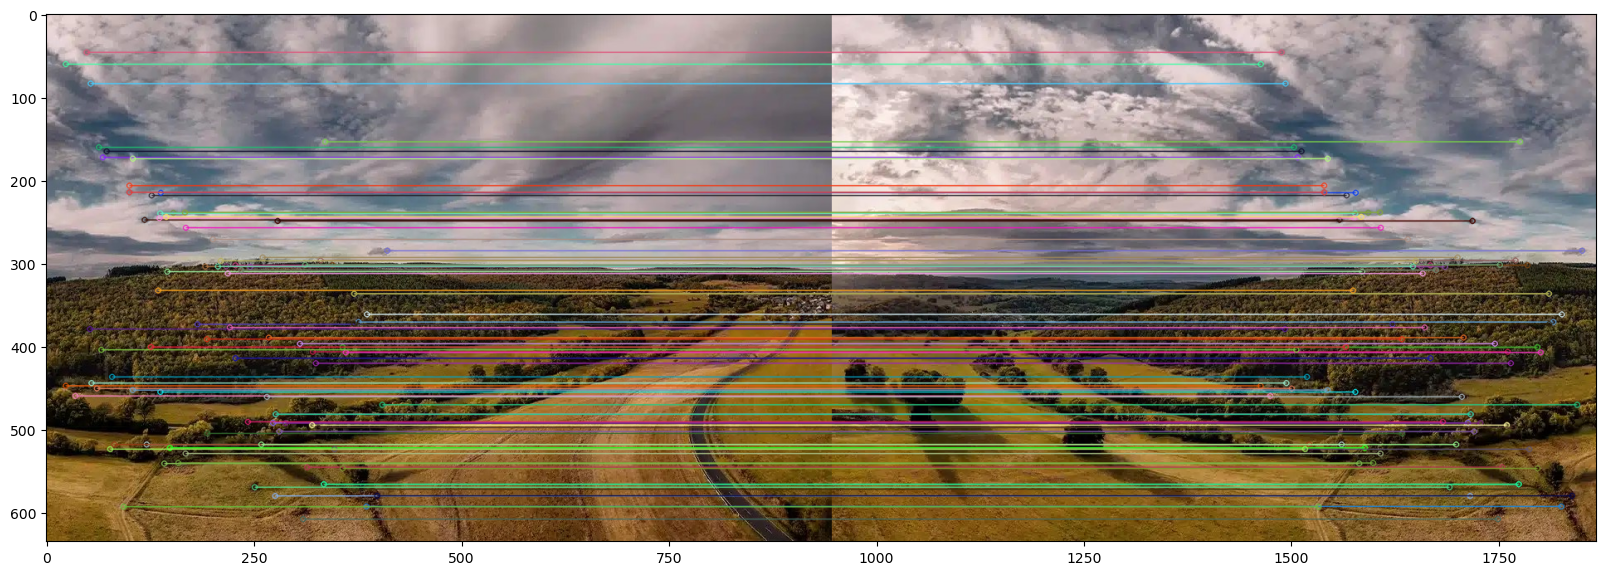

In [59]:
print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img, method=feature_extraction_algo)
    
    mapped_features_image = cv2.drawMatches(train_photo,keypoints_train_img,query_photo,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Now for cross checking draw the feature-mapping lines also with KNN
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img, ratio=0.75, method=feature_extraction_algo)
    
    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(mapped_features_image)

In [60]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh):   

    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])
    
    #minimum correspondence points btw 2 images -assumption
    if len(matches) > 4:
        # construct the two sets of points
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])
        
        # Calculate the homography between the sets of points
        (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [61]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh=4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 1.00033397e+00  2.71310944e-04  4.92950520e+02]
 [ 9.86865932e-05  1.00026537e+00 -5.52186819e-02]
 [ 2.98537060e-07  2.82027553e-07  1.00000000e+00]]


width  1868


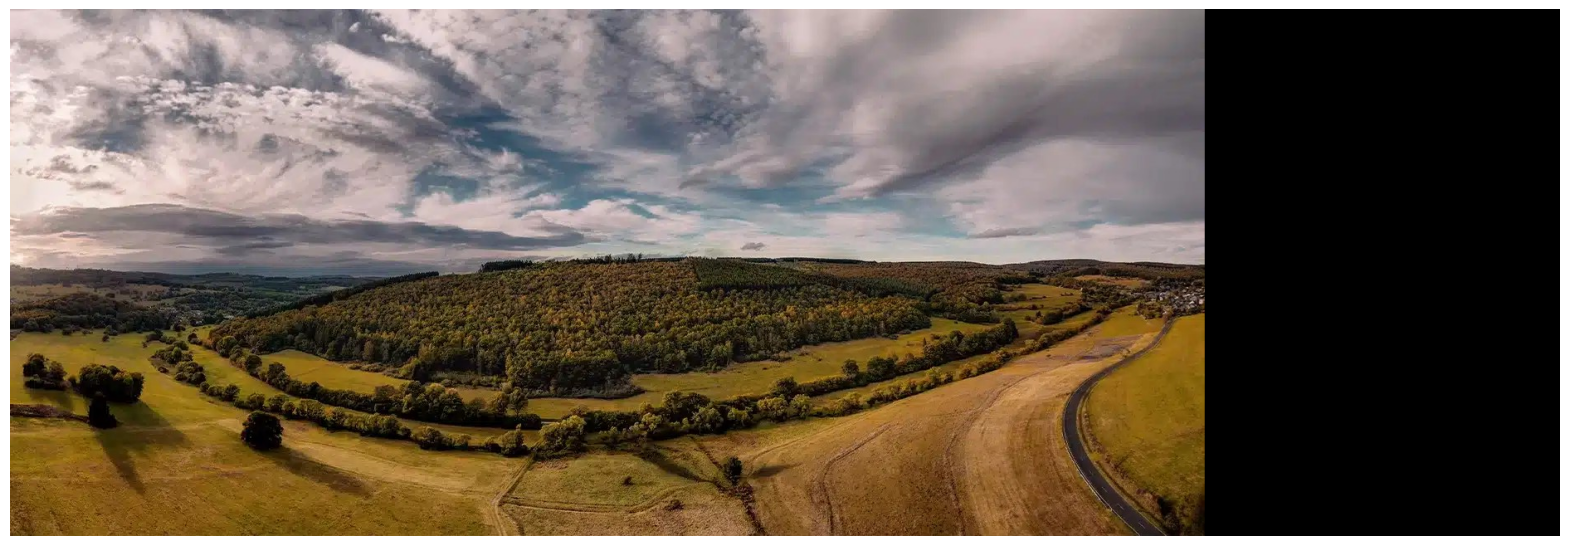

In [62]:


width = query_photo.shape[1] + train_photo.shape[1]
print("width ", width) 
# 2922 - Which is exactly the sum value of the width of 
# my train.jpg and query.jpg


height = max(query_photo.shape[0], train_photo.shape[0])

result = cv2.warpPerspective(train_photo, Homography_Matrix,  (width, height))

result[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)


plt.show()